## 1.2.4c. Pearson correlation Baccin dataset

In this Notebook we will compare our dataset with the dataset published in Baccin et al. 2019 (https://doi.org/10.1038/s41556-019-0439-6). Their preprocessed and filtered count matrix can be found using GEO code GSE122465 (https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE122465). Here, you can download the `FilteredCounts10x.csv` file. This file includes only the count matrix, but not the cluster assignments for each cell. The assigned clusters, and the t-SNE coordinates can be found in the Seurat object that is part of the Supplementary Data (see the publication). You can use R script 1.2.4a to extract the clusters and t-SNE coordinates yourself, but you can also use the files `clusters.csv` and `tsne_coordinates.csv` in the `data/public_datasets/Baccin_2019` folder on the Github repository.

In Notebook 1.2.4b we compared the control subset with the Baccin dataset by plotting both in one UMAP. Here, we will focus on the Pearson correlation between the clusters in both datasets. In order to do this we need the preprocessed datasets, but we will not batch correct them. 

In [1]:
### loading python libraries

# standard libraries
import numpy as np
import pandas as pd

# single cell libraries
import anndata as ad
import scanpy as sc
sc.settings.verbosity = 0 

# plotting libraries
from matplotlib import pyplot as plt
import seaborn as sns; sns.set_theme() #for plotting the heatmap

# other 
import warnings
warnings.filterwarnings('ignore') #ignore filter warnings
import sklearn as sk #used for L2 normalization
import sklearn.preprocessing #used for L2 normalization
import scipy #for making sparse matrix from dense
from scipy.cluster.hierarchy import linkage, leaves_list #for hiearchical clustering
from scipy.spatial.distance import pdist #for hiearchical clustering

# import own functions
from utils import *

### Load data

First, we load the preprocessed control subset (as filtered in notebook 1.1).

In [2]:
### load Anndata object with the control subset 
adata_path = "../data/count_matrices/control_filtered.h5ad"
adata = sc.read_h5ad(adata_path)

Then, we load the Baccin data and apply some preprocessing/filtering steps that we have also applied to the control dataset.

In [3]:
### load haas data in dataframe
baccin_data_path = "../data/public_datasets/Baccin_2019/FilteredCounts10x.csv"
baccin_data = pd.read_csv(baccin_data_path, header=0, index_col=0)
baccin_data = baccin_data.T

In [4]:
### create Anndata object with Baccin data
adata_baccin = ad.AnnData(X=baccin_data)

In [5]:
### make sparse matrix
adata_baccin.X = scipy.sparse.csr_matrix(baccin_data.values)

In [6]:
### preprocess Baccin data
adata_baccin = filter_data(adata_baccin, mito_perc=5, min_genes=700, no_doublet=False, no_negative=False)

Trying to set attribute `.obs` of view, copying.


In [7]:
### add clusters to Baccin data
clusters_path = "../data/public_datasets/Baccin_2019/clusters.csv"
clusters = pd.read_csv(clusters_path, index_col=0)
adata_baccin.obs["clusters_baccin"] = clusters

In [8]:
### add tsne coordinates to Baccin data
coordinates_path = "../data/public_datasets/Baccin_2019/tsne_coordinates.csv"
coordinates = pd.read_csv(coordinates_path, index_col=0)
adata_baccin.obsm["X_tsne"] = coordinates.loc[adata_baccin.obs_names.values]

In [9]:
### find shared genes
shared_genes = adata.var_names.intersection(adata_baccin.var_names)

### subset for shared genes
adata = adata[:, shared_genes]
adata_baccin = adata_baccin[:, shared_genes]

In [10]:
### L2 normalize datasets
adata.X = sk.preprocessing.normalize(adata.X, norm='l2')
adata_baccin.X = sk.preprocessing.normalize(adata_baccin.X, norm='l2')

### Pearson correlation

Here, we want get a Pearson correlation between each cluster in the Baccin dataset and the control subset. This is a different way of getting an idea if the clusters that we assigned to our clusters are similar to the clusters that were assigned in the Baccin paper. A Pearson correlation coefficient is normally a score between -1 and 1, were 1 stands for a strong positive relationship and -1 an strong negative relationship. 0 indicates no relationship at all. In our case we expect values only between 0 and 1.

In [11]:
### get mean expression per cluster for control subset
expression = adata.X.toarray()
expression = pd.DataFrame(expression,
                          columns=adata.var_names,
                          index=adata.obs["clusters"])
mean_expr_adata = expression.groupby(level=0).mean()

In [12]:
### get mean expression per cluster for Baccin dataset
expression = adata_baccin.X.toarray()
expression = pd.DataFrame(expression,
                          columns=adata_baccin.var_names,
                          index=adata_baccin.obs["clusters_baccin"])
mean_expr_baccin = expression.groupby(level=0).mean()

In [13]:
mean_expr = pd.concat([mean_expr_adata, mean_expr_baccin])

In [14]:
### get Pearson correlation
pearson_corr = pd.DataFrame(np.corrcoef(mean_expr),
                            columns=mean_expr.index, 
                            index=mean_expr.index)

length = len(adata.obs["clusters"].unique())
pearson_corr = pearson_corr.iloc[0:length,length:len(pearson_corr)]

### Plot Pearson correlation

Here, we will plot the calculated Pearson correlation between the control dataset and the Baccin dataset in a heatmap.

In [15]:
### calculate hierarchical clustering
Y = pdist(pearson_corr.values)
Z = linkage(Y, "ward")
A = pdist(pearson_corr.values.T)
B = linkage(A, "ward")

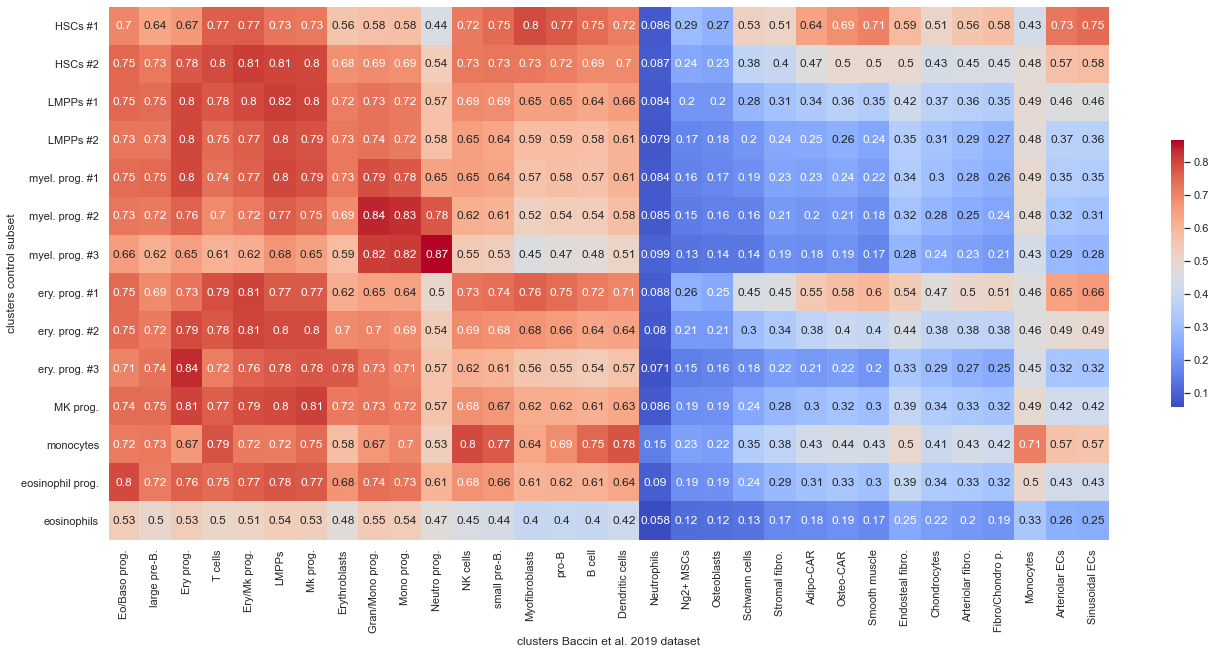

In [16]:
fig, axs = plt.subplots(1,1,figsize=(pearson_corr.shape[1]*0.7,pearson_corr.shape[0]*0.7))

heatmap = sns.heatmap(pearson_corr.iloc[:,leaves_list(B)], 
                      cmap="coolwarm", cbar_kws={"shrink": 0.5}, 
                      annot=True)
axs.set_xlabel("clusters Baccin et al. 2019 dataset")
axs.set_ylabel("clusters control subset")
axs.yaxis.set_label_position("left")

#save_path = "../figures/1.2.4.Pearson_correlation_Baccin_vs_control.png"
#fig.savefig(save_path, bbox_inches='tight', format='png', dpi=300)

plt.show()